# Final Project - Medical Diagnosis Clustering Based on Symptoms

### Importing and cleaning data

In [19]:
from datasets import load_dataset
import matplotlib.pyplot as plt

dataset = load_dataset("aai530-group6/ddxplus")

Found cached dataset csv (/Users/julesgeneser/.cache/huggingface/datasets/aai530-group6___csv/aai530-group6--ddxplus-8602e7bf22329c41/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE'],
        num_rows: 1025602
    })
    test: Dataset({
        features: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE'],
        num_rows: 134529
    })
})


In [21]:
import pandas as pd
import ast

# Dataset has 1 million rows. We will focus on the first 10,000
# Load into dataframe
diagnosis = dataset['train'].select(range(10000))
df = pd.DataFrame(diagnosis)

# Get rid of column that displays results of ML algo this dataset was originally used for
df = df.drop("DIFFERENTIAL_DIAGNOSIS", axis=1)

# Checking how many unique elements there are
df['EVIDENCES'] = df['EVIDENCES'].apply(ast.literal_eval)

# Initialize a set to hold unique elements across all rows
unique_elements = set()

for row in df['EVIDENCES']:
    # Using update to add elements from each list in the EVIDENCES column
    unique_elements.update(row)

# Create new columns for each unique element
new_columns = pd.DataFrame({evidence: df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0) for evidence in unique_elements})

# Concatenate the new columns with the original DataFrame
df = pd.concat([df, new_columns], axis=1)

# Drop the original 'EVIDENCES' column
df = df.drop('EVIDENCES', axis=1)

In [22]:
df.head(10)

,AGE,SEX,PATHOLOGY,INITIAL_EVIDENCE,E_152_@_V_120,E_133_@_V_39,E_152_@_V_34,E_204_@_V_6,E_54_@_V_11,E_129,...,E_148,E_55_@_V_137,E_55_@_V_149,E_160,E_40,E_204_@_V_1,E_55_@_V_34,E_38,E_152_@_V_35,E_133_@_V_110
0,18,M,URTI,E_91,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21,M,HIV (initial infection),E_50,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
2,19,F,Pneumonia,E_77,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,34,F,URTI,E_53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,36,M,URTI,E_201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,37,F,Chronic rhinosinusitis,E_53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,43,M,Viral pharyngitis,E_53,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7,39,M,Anemia,E_88,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,30,M,Chronic rhinosinusitis,E_53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,49,M,Atrial fibrillation,E_66,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### K - Means Algorithm 

In [23]:
import numpy as np
#Hamming distance here 
def distance(a, b):
    return np.mean(a!=b)
    
def k_modes(df_binary, k, max_iter=100):
    # Randomly initialize the cluster centers
    initial_clusters = df_binary.sample(n=k).values
    cluster_assignments = np.zeros(df_binary.shape[0], dtype=int)

    for iteration in range(max_iter):
        # Initialize an empty list to store new cluster centers
        new_clusters = [np.zeros(df_binary.shape[1]) for _ in range(k)]
        cluster_sizes = [0] * k

        # Assign each point to the nearest cluster
        for i, row in df_binary.iterrows():
            dissimilarities = [distance(row.values, cluster) for cluster in initial_clusters]
            closest_cluster = np.argmin(dissimilarities)
            cluster_assignments[i] = closest_cluster
            new_clusters[closest_cluster] += row.values
            cluster_sizes[closest_cluster] += 1

        # Update cluster centers
        for j in range(k):
            if cluster_sizes[j] > 0:
                new_clusters[j] /= cluster_sizes[j]
                new_clusters[j] = np.round(new_clusters[j])  # Convert to binary format

        # Check for convergence (if clusters did not change)
        if np.array_equal(initial_clusters, new_clusters):
            break

        initial_clusters = new_clusters

    return cluster_assignments

In [24]:
# Identify binary columns
binary_columns = [col for col in df.columns if df[col].nunique() == 2 and df[col].dropna().isin([0, 1]).all()]
df_binary = df[binary_columns]
#Cluster
clusters = k_modes(df_binary, 20)

#### Let's explore, with so many attributes, plotting as clusters on scatterplot will be tough, let's just look at all of the actual diagnoses in a group and see if they look similar

In [25]:
def extract_diagnosis_for_cluster(df, cluster_labels, cluster_num):
    # Convert cluster_labels to a pandas Series to facilitate indexing
    cluster_series = pd.Series(cluster_labels, index=df.index)
    
    # Filter df where cluster label is cluster_num
    cluster_df = df[cluster_series == cluster_num]

    # Return or print the 'PATHOLOGY'
    return cluster_df['PATHOLOGY']

#### Look at Clusters Made

In [40]:
# Identify binary columns
binary_columns = [col for col in df.columns if df[col].nunique() == 2 and df[col].dropna().isin([0, 1]).all()]
df_binary = df[binary_columns]
#Cluster
k = 20
clusters = k_modes(df_binary, k)

In [41]:
cluster_5 = extract_diagnosis_for_cluster(df, clusters, 0)
counts_5 = cluster_5.value_counts()
print(counts_5)

Tuberculosis                                178
Bronchospasm / acute asthma exacerbation    162
Acute COPD exacerbation / infection          66
Pancreatic neoplasm                          56
Spontaneous rib fracture                     36
Pulmonary neoplasm                           18
Bronchiectasis                               13
Ebola                                         7
GERD                                          6
Allergic sinusitis                            3
Bronchitis                                    2
Bronchiolitis                                 1
Name: PATHOLOGY, dtype: int64


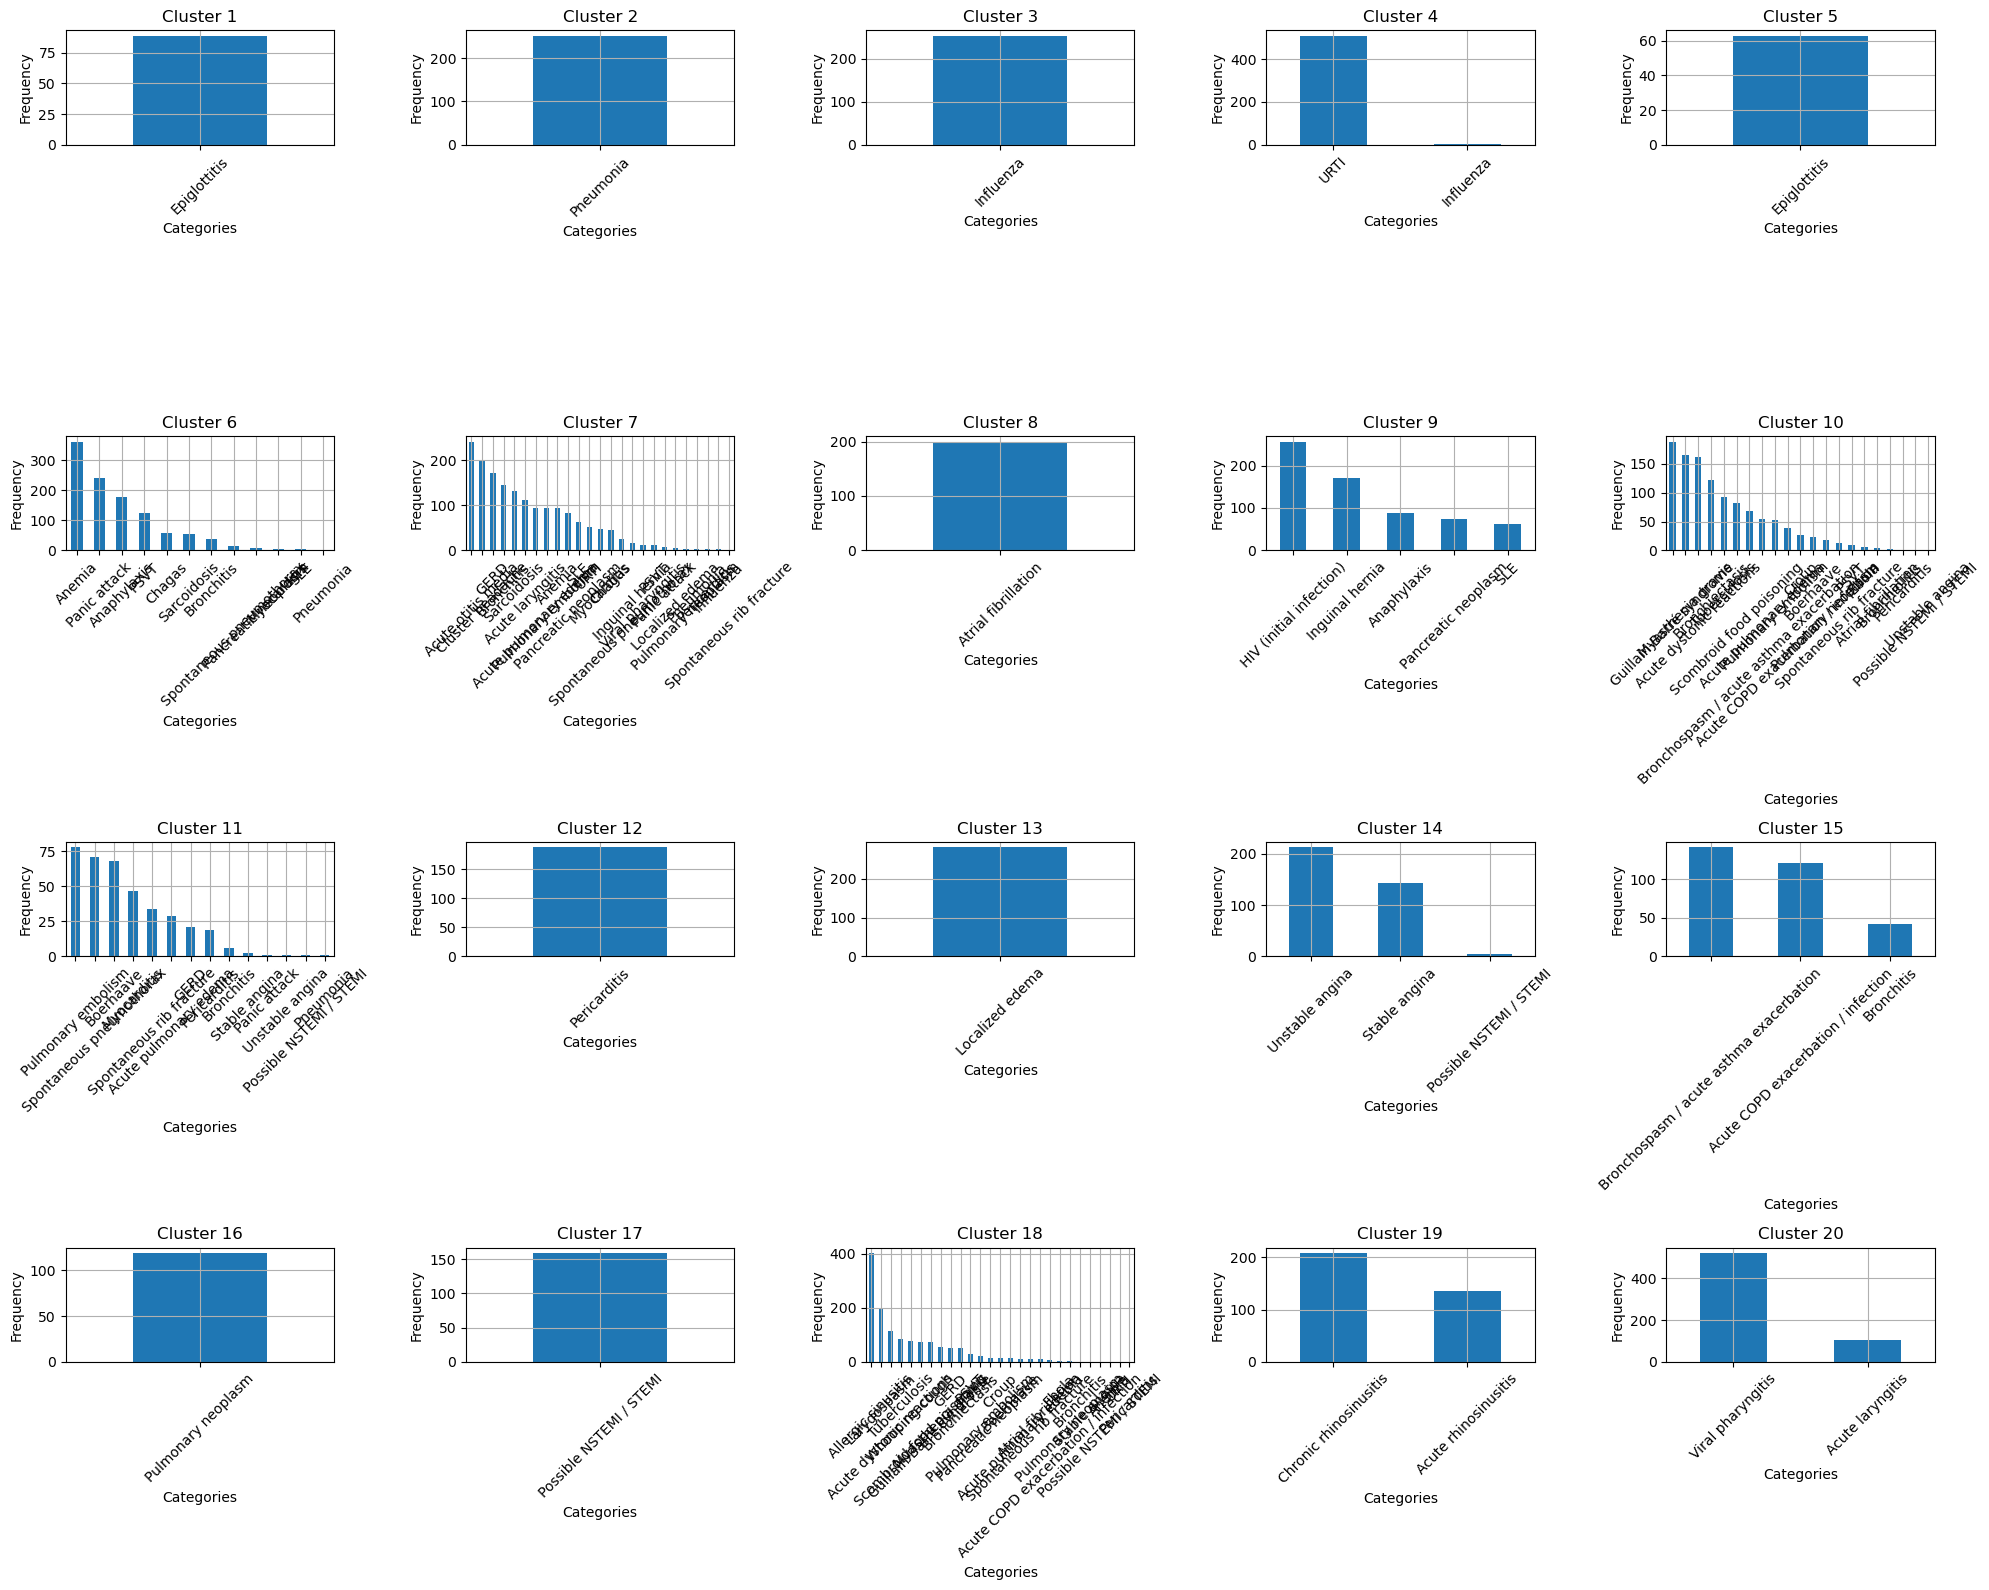

In [42]:
fig, axs = plt.subplots(4, 5, figsize=(20, 16))

for i, ax in enumerate(axs.flat):
    cluster_n = extract_diagnosis_for_cluster(df, clusters, i)
    counts_n = cluster_n.value_counts()
    counts_n.plot(kind='bar', ax=ax)
    ax.set_title(f'Cluster {i+1}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(counts_n.index, rotation=45)
    ax.grid(True)

plt.tight_layout()
plt.show()

##### Plot the different diagnoses we get with cluster 5

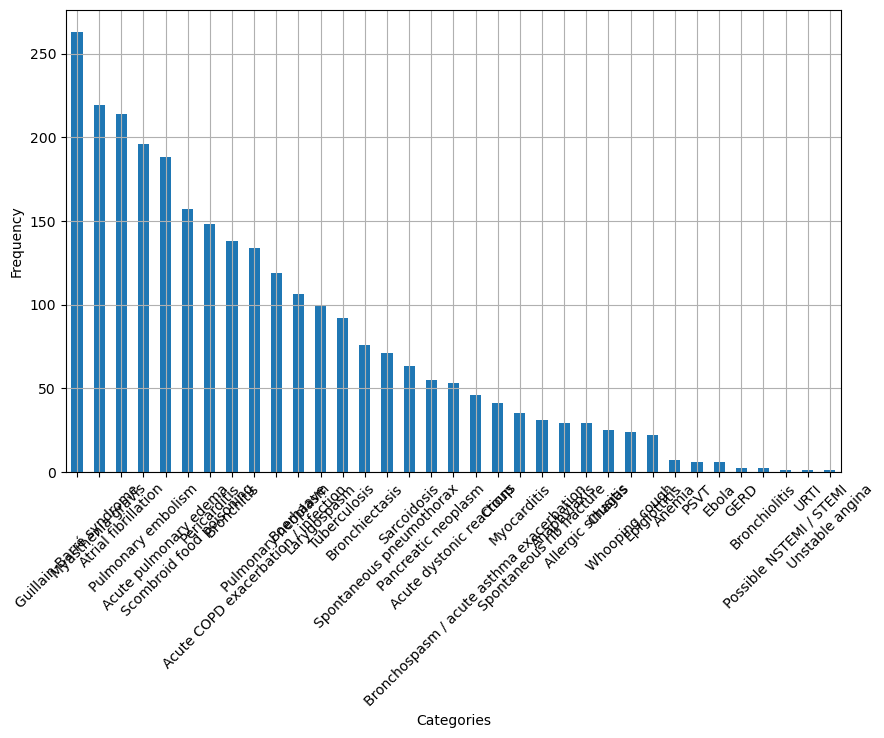

In [27]:
plt.figure(figsize=(10, 6)) 
counts_5.plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##### Cluster 7

In [28]:
cluster_7 = extract_diagnosis_for_cluster(df, clusters, 7)
counts_7 = cluster_7.value_counts()
print(counts_7)

Pneumonia    252
Name: PATHOLOGY, dtype: int64


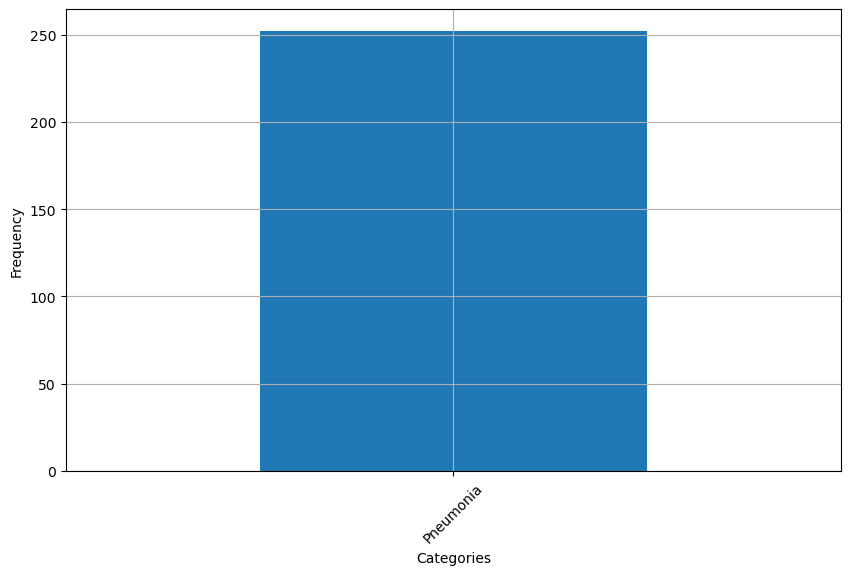

In [29]:
plt.figure(figsize=(10, 6)) 
counts_7.plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##### Cluster 1

In [30]:
cluster_3 = extract_diagnosis_for_cluster(df, clusters, 1)
counts_3 = cluster_3.value_counts()
print(counts_3)

Unstable angina            214
Stable angina              146
Possible NSTEMI / STEMI      5
Acute pulmonary edema        1
Name: PATHOLOGY, dtype: int64


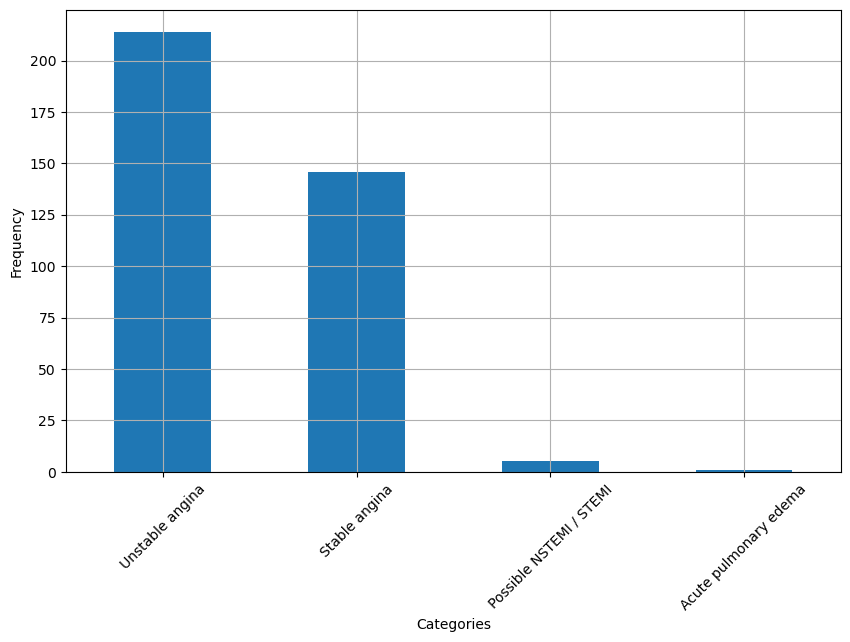

In [31]:
plt.figure(figsize=(10, 6)) 
counts_3.plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()